In [25]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
from d2l import torch as d2l

In [26]:
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        if use_1x1conv == True:
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides) 
            #为了和主链的高宽一致，要加stride
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [27]:
def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
    # 定义残差块，first_block=False代表了此残差块会将通道加倍，宽高减半；first_block=True代表了此残差块通道与宽高均不变。
    # 即第一个不减半，其余都减半
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,use_1x1conv=True,strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [28]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [29]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [30]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10)).cuda()

In [31]:
X = torch.rand(size=(1, 1, 224, 224), device='cuda:0')
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


In [32]:
def train(net, train_iter, test_iter, num_epochs, lr, T_max, num_gpus): 
    """用GPU训练模型，模型使用Adam，损失函数是交叉熵，学习率调度器使用余弦退火，采用多GPU设置模型"""
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    net = nn.DataParallel(net) 
    # DataParallel在多个GPU上设置模型
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    # 定义一个周期的迭代次数
    lr_scheduler = CosineAnnealingLR(optimizer, T_max)
    # 定义余弦退火的学习率调度器
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'],ylim=[0,3.5])# 动图生成函数，包括训练损失，训练平均精确度，测试平均精确度
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)# 训练损失之和，训练准确率之和，样本数
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.cuda(), y.cuda() #训练集的数据移动到device上
            y_hat= net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))# 此处是为了显示图像更方便，拆分等分显示图片
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
        lr_scheduler.step()
        # 每次epoch进行余弦退火的学习率调整
    print(f'loss {train_l:.3f}, 训练精度{train_acc:.3f}, '
          f'测试精度 {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec,'
          f'平均批次时间 {timer.sum() / num_epochs:.3f} sec',f'在{str(devices)}')

loss 0.192, 训练精度0.929, 测试精度 0.902
2820.2 examples/sec,平均批次时间 21.275 sec 在[device(type='cuda', index=0), device(type='cuda', index=1)]


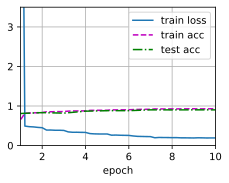

In [33]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
lr, num_epochs= 0.1, 10
train(net, train_iter, test_iter, num_epochs, lr, T_max=8, num_gpus=2)